In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:
from sklearn.model_selection import train_test_split
from keras.layers import Dense , LSTM , Embedding , Dropout , Activation , Flatten
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

There was 2 main problems with RNN and that was 
* Long term dependency problem in RNNs.
* Vanishing Gradient & Exploding Gradient.

**And then in 1997 LSTM came into light and solved these problems**

LSTM consists of 4 Gates 
* Input Gate 
* Forget Gate
* Candidate Gate
* Output Gate


Forget gate
> Controls whether to erase data from the cell-state.

Input gate
> Controls whether to write data to the cell-state.

Candidate gate
> Controls what data to write to the cell-state.

Output gate
> Controls what data to pass as the output hidden state.

![ equation lstm ](https://miro.medium.com/max/1400/1*ryIzdQtDwrdx_sJHdufrEQ.png) ![]()


![ lstm ](https://www.mdpi.com/sensors/sensors-21-05625/article_deploy/html/images/sensors-21-05625-g001.png) ![]()


# Load the data

In [3]:
data = pd.read_csv('../input/sms-spam-collection-dataset/spam.csv',delimiter=',',encoding='latin-1')

In [4]:
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [5]:
data.describe().T

,count,unique,top,freq
v1,5572,2,ham,4825
v2,5572,5169,"Sorry, I'll call later",30
Unnamed: 2,50,43,"bt not his girlfrnd... G o o d n i g h t . . .@""",3
Unnamed: 3,12,10,"MK17 92H. 450Ppw 16""",2
Unnamed: 4,6,5,"GNT:-)""",2


In [6]:
data.shape

(5572, 5)

In [7]:
data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

# Droping Features because of a lot of missing values

In [8]:
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='v1', ylabel='count'>

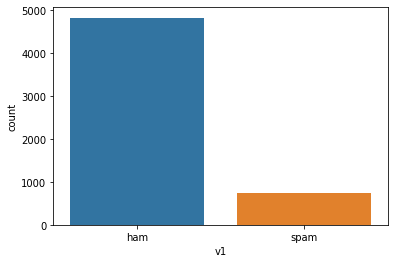

In [9]:
sns.countplot(data.v1)

**The Data is Vers Skewed to ham**

# Label Encoding

In [10]:
X = data.v2
Y = data.v1
le = LabelEncoder()
Y = le.fit_transform(Y)

In [11]:
Y = Y.reshape(-1,1)

In [12]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)

# Text Process

In [13]:
max_word = 1000
max_len = 250
token = Tokenizer(num_words = max_word)
token.fit_on_texts(X_train)
sequences = token.texts_to_sequences(X_train)
seq_matrix = sequence.pad_sequences(sequences , maxlen = max_len)

# Building the LSTM model

In [14]:
#Model
model = Sequential()
model.add(Embedding(max_word , 32 , input_length = max_len))
model.add(LSTM(64))
model.add(Flatten())

model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(120, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

2022-09-15 06:07:11.799254: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
# Compile the model
model.compile(loss = 'binary_crossentropy' , optimizer = 'RMSprop' , metrics = 'accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 32)           32000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 250)               16250     
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30120     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [16]:
model.fit(seq_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10


2022-09-15 06:07:12.257740: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


28/28 [==============================] - 12s 360ms/step - loss: 0.3384 - accuracy: 0.8676 - val_loss: 0.1561 - val_accuracy: 0.9765


In [17]:
test_seq = token.texts_to_sequences(X_test)
test_seq_matrix = sequence.pad_sequences(test_seq,maxlen=max_len)

In [18]:
scores = model.evaluate(test_seq_matrix, Y_test, verbose=0)
scores

[0.16472172737121582, 0.9784753322601318]

In [19]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 97.85%
